In [3]:
#Importing necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [5]:
#Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission.csv')

## EDA

In [6]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [7]:
train.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'Offset_fault'],
      dtype='object')

In [7]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
mean,40.751195,38.183018,23.316554,78.653623,0.371072
std,28.526182,28.647761,3.836971,14.772725,0.483092
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


In [8]:
test.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
count,127361.000000,127361.000000,39271.000000,39271.000000
mean,42.795356,43.958427,23.683838,72.215834
std,27.838730,28.260335,3.725563,18.078569
min,1.230000,0.780000,16.900000,28.000000
25%,24.670000,25.580000,20.900000,58.000000
50%,39.770000,39.880000,22.500000,78.000000
75%,52.030000,52.830000,26.500000,88.000000
max,927.780000,894.750000,34.000000,97.000000


In [9]:
train.isna().sum()

ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

In [10]:
test.isna().sum()

ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
dtype: int64

In [11]:
#I will drop all where Sensor1_PM2.5 and Sensor2 is na in the train
#because in test no missing in sensor1 and 2

In [12]:
(train['Sensor1_PM2.5'].isna()) & (train['Sensor2_PM2.5'].isna())

0         False
1         False
2         False
3         False
4         False
          ...  
297172    False
297173    False
297174    False
297175    False
297176    False
Length: 297177, dtype: bool

In [13]:
# THis give the rows without na in both Sensor1 and 2
train = train[~((train['Sensor1_PM2.5'].isna()) & (train['Sensor2_PM2.5'].isna()))]

In [14]:
#the new train and there is still missng in the temperature and relative_hum
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,290014.000000,290014.000000,293563.000000
mean,40.751195,38.183018,23.322738,78.614394,0.370387
std,28.526182,28.647761,3.841953,14.791905,0.482909
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


Due to the fact that this is a Time series data the missing will be best filled forwardly

In [15]:
train = train.sort_values(by = 'Datetime')

In [16]:
train = train.fillna(method = 'ffill')

In [17]:
# #a function to fill missing with mean by default
# def fill_missing(data, col, fill='mean'):
#     if fill == 'mean':
#         mean_fill = data[col].mean()
#         filled_col = data[col].fillna(mean_fill)
#     else:
#         filled_col = data[col].fillna(fill)
            
#     return filled_col

In [18]:
# #filling missing values in columns
# train['Temperature'] = fill_missing(train, 'Temperature')
# train['Relative_Humidity'] = fill_missing(train, 'Relative_Humidity')

# train['Sensor1_PM2.5'] = fill_missing(train, 'Sensor1_PM2.5', fill = 42)
# train['Sensor2_PM2.5'] = fill_missing(train, 'Sensor2_PM2.5', fill = 43)

In [19]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [20]:
test.sort_values(by='Datetime', inplace=True)

In [21]:
test = test.fillna(method='ffill')

In [22]:
#everything is settled
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,293563.000000,293563.000000,293563.000000
mean,40.751195,38.183018,23.354929,78.505374,0.370387
std,28.526182,28.647761,3.852468,14.851078,0.482909
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,22.000000,83.000000,0.000000
75%,49.420000,47.570000,26.400000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


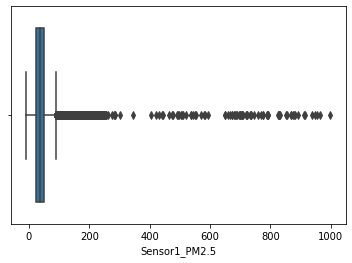

In [23]:
sns.boxplot(train['Sensor1_PM2.5'])

## Feature Engineering

In [24]:
# train['logSensor1_PM2.5'] = np.log(train['Sensor1_PM2.5'])

In [25]:
# sns.boxplot(train['logSensor1_PM2.5'])

In [26]:
def date_preprocessing(data):
    # get a days difference from a given date
    data['datediff'] =(pd.to_datetime("2022-03-19 11:01:18.751351") - pd.to_datetime(data['Datetime'])).dt.days
    
    # Extract day, month and year from the Datetime column
    data['Datetime_day'] = pd.to_datetime(data['Datetime']).dt.day
    data['Datetime_month'] = pd.to_datetime(data['Datetime']).dt.month
    data['Datetime_hour'] = pd.to_datetime(data['Datetime']).dt.hour
    
    return data

    
    
def feat_generation(data):
    #feature generation
    
    data['sensorcombo'] = (data['Sensor1_PM2.5'] + data['Sensor2_PM2.5'])/2
    data['diffsensor'] = (data['Sensor1_PM2.5'] - data['Sensor2_PM2.5'])

    data['temp/hum'] = data['Relative_Humidity']/data['Temperature']
    
    return data

In [27]:
#processing date column and also generating new features
train = date_preprocessing(train)

#generating features from sensor
train = feat_generation(train)

#previewed engineered train
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,datediff,Datetime_day,Datetime_month,Datetime_hour,sensorcombo,diffsensor,temp/hum
116880,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17,9.28,29.9,53.0,0,154,15,10,16,9.225,-0.11,1.772575
220210,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93,11.25,29.9,53.0,0,154,15,10,16,10.590,-1.32,1.772575
260869,ID_UF68QLIPG3LE,2021-10-15 16:01:01,6.53,3.15,29.9,53.0,1,154,15,10,16,4.840,3.38,1.772575
200775,ID_KKCO4VATOSWB,2021-10-15 16:01:54,8.30,8.35,29.9,53.0,0,154,15,10,16,8.325,-0.05,1.772575
164575,ID_8YNKABZP11SS,2021-10-15 16:02:06,6.87,9.57,29.9,53.0,0,154,15,10,16,8.220,-2.70,1.772575


In [28]:
def outliers_removal(data, col, IQR = True):
    if IQR:
        q75 = np.quantile(train[col], q = 0.75)
        q25 = np.quantile(train[col], q = 0.25)
        IQR = q75 - q25
        to_replace = q75 + 1.5 * IQR
    print(to_replace)
    data[col] = np.where((data[col] >= to_replace), to_replace, data[col] )
    
    sns.boxplot(train[col])  

89.3875


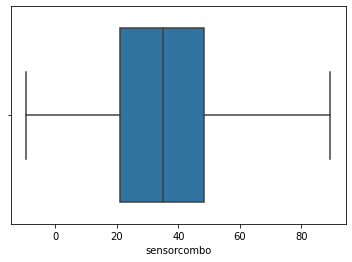

In [29]:
outliers_removal(train, 'sensorcombo')

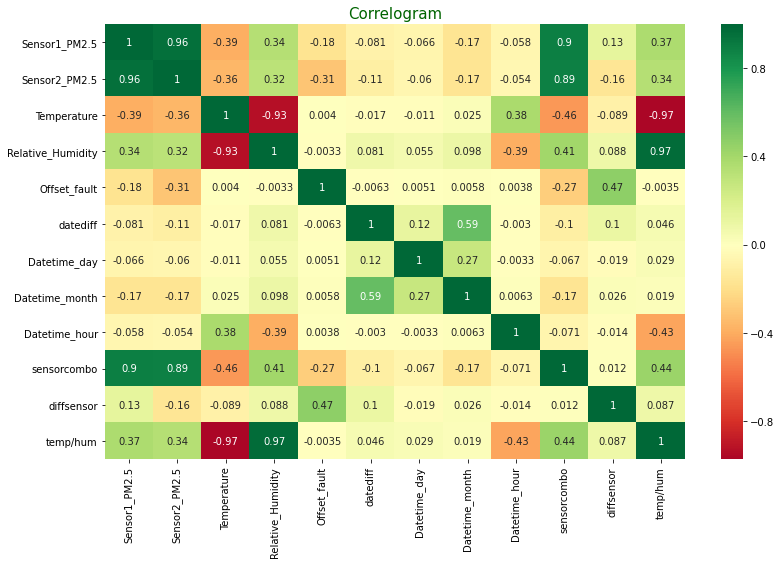

In [30]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

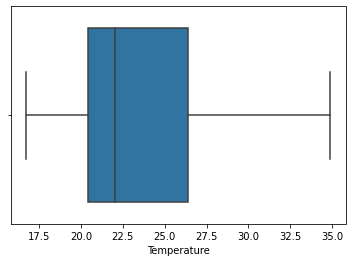

In [31]:
sns.boxplot(train['Temperature'])

In [32]:
train.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'Offset_fault', 'datediff', 'Datetime_day',
       'Datetime_month', 'Datetime_hour', 'sensorcombo', 'diffsensor',
       'temp/hum'],
      dtype='object')

### Test Data

In [33]:
# test['logSensor1_PM2.5'] = np.log(test['Sensor1_PM2.5'])

In [34]:
#processing date column and also generating new features
test = date_preprocessing(test)

#generating features from sensor
test = feat_generation(test)

#previewed engineered train
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,datediff,Datetime_day,Datetime_month,Datetime_hour,sensorcombo,diffsensor,temp/hum
11525,ID_H9H3ENR9M13N,2022-01-21 07:35:50,43.92,50.28,16.9,79.0,57,21,1,7,47.100,-6.36,4.674556
45065,ID_JLD6XFEW7EAM,2022-01-21 07:36:01,49.52,46.80,16.9,79.0,57,21,1,7,48.160,2.72,4.674556
76427,ID_OQ01HEDYRZEU,2022-01-21 07:36:07,41.47,32.08,16.9,79.0,57,21,1,7,36.775,9.39,4.674556
12285,ID_NHK3H46SLYA2,2022-01-21 07:37:21,38.07,32.60,16.9,79.0,57,21,1,7,35.335,5.47,4.674556
29831,ID_NGRS57K2NFUF,2022-01-21 07:37:21,49.02,44.20,16.9,79.0,57,21,1,7,46.610,4.82,4.674556


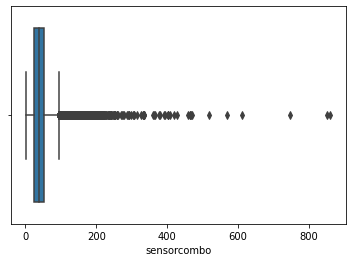

In [35]:
sns.boxplot(test['sensorcombo'])

89.3875


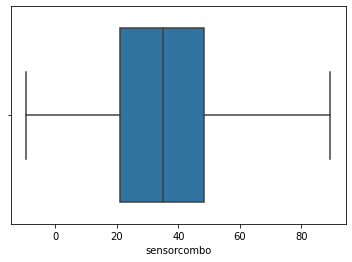

In [36]:
outliers_removal(test, 'sensorcombo')

In [37]:
train.drop('Offset_fault', axis = 1).columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## Baseline Model

In [39]:
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
feats = ['Temperature', 'Relative_Humidity', 'datediff','diffsensor',
       'sensorcombo', 'Datetime_day', 'Datetime_month', 'temp/hum',
       'Datetime_hour']

X = train[feats]
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
clf = RandomForestClassifier(max_depth = 7, n_estimators=1000, random_state = 0)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

#Accuracy score: 0.9287831132407544


Accuracy score: 0.929714201364839


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55539
           1       0.92      0.89      0.90     32530

    accuracy                           0.93     88069
   macro avg       0.93      0.92      0.92     88069
weighted avg       0.93      0.93      0.93     88069



In [41]:
import pickle
import joblib

In [42]:
# # save the model to disk
# filename = 'saved_model.sav'
# pickle.dump(clf, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [43]:
# save the model to disk
filename = 'saved_model.sav'
joblib.dump(clf, filename)

['saved_model.sav']

In [44]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.929714201364839


In [45]:
submission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


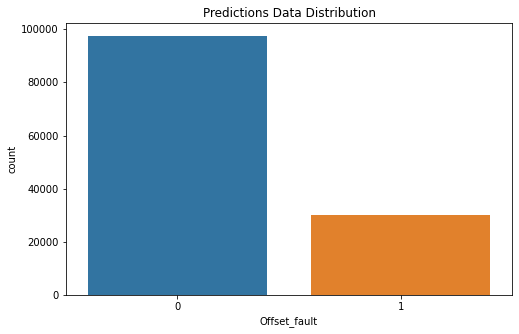

In [48]:
# Make prediction on the test set
test_df = test[feats]
predictions = clf.predict(test_df)

submission['Offset_fault'] = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(submission.Offset_fault)
plt.title('Predictions Data Distribution');

In [49]:
# Create file
submission.to_csv('growthrf.csv', index = False)

In [50]:
submission['Offset_fault'].value_counts()

0    97443
1    29918
Name: Offset_fault, dtype: int64

In [51]:
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
feats = ['Temperature', 'Relative_Humidity', 'datediff','diffsensor',
       'sensorcombo', 'Datetime_day', 'Datetime_month', 'temp/hum',
       'Datetime_hour']

X = train[feats]
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
clf = RandomForestClassifier(n_estimators = 1000, max_depth = 7, random_state = 0)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.9290215626383858


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55518
           1       0.91      0.89      0.90     32551

    accuracy                           0.93     88069
   macro avg       0.93      0.92      0.92     88069
weighted avg       0.93      0.93      0.93     88069



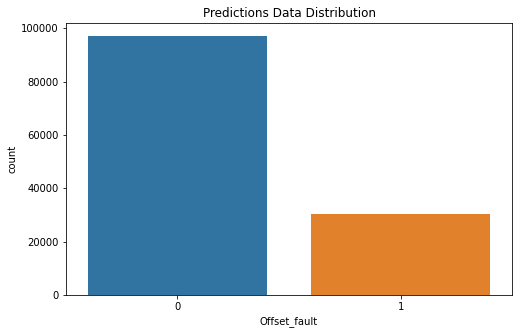

In [52]:
# Make prediction on the test set
test_df = test[feats]
predictions = clf.predict(test_df)

submission['Offset_fault'] = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(submission.Offset_fault)
plt.title('Predictions Data Distribution');

In [53]:
# Create file
submission.to_csv('growthrf1000.csv', index = False)

In [54]:
submission['Offset_fault'].value_counts()

0    97086
1    30275
Name: Offset_fault, dtype: int64

Other models

In [46]:
y
X = train[feats]
testdf = test[feats]

kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.2
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0,random_state=43)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(accuracy_score(y_test,cat.predict(X_test)))
    cat_proba.append(accuracy_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(accuracy_score(y_test,cat.predict(X_test)))
    #print(accuracy_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict(testdf)

print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
print(np.where(cat_pred/5 > thresh, 1, 0).sum())

#feat_imp_ploter(cat, X)

================================Fold0====================================
0.9619505049988929
================================Fold1====================================
0.9628532011649891
================================Fold2====================================
0.9619164409926252
================================Fold3====================================
0.9613196620793023
================================Fold4====================================
0.9600933369668893
Index(['Temperature', 'Relative_Humidity', 'datediff', 'diffsensor',
       'sensorcombo', 'Datetime_day', 'Datetime_month', 'temp/hum',
       'Datetime_hour'],
      dtype='object')
0.9616266292405398
0.9460286133196805
55241


In [47]:
print(f'{classification_report(y_test, cat.predict(X_test))}')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36966
           1       0.95      0.94      0.95     21746

    accuracy                           0.96     58712
   macro avg       0.96      0.96      0.96     58712
weighted avg       0.96      0.96      0.96     58712



In [ ]:
print(f'{classification_report(y_test, cat.predict(X_test))}')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36966
           1       0.95      0.95      0.95     21746

    accuracy                           0.96     58712
   macro avg       0.96      0.96      0.96     58712
weighted avg       0.96      0.96      0.96     58712



In [ ]:
pred_cat = np.where(cat_pred/5 > 0.6, 1, 0)

In [ ]:
submission['Offset_fault'] = pred_cat

Text(0.5, 1.0, 'Predictions Data Distribution')

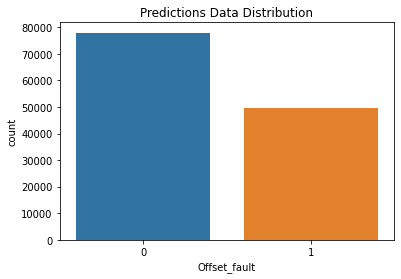

In [ ]:
# Check the distribution of your predictions
#plt.figure(figsize=(8, 5))
sns.countplot(submission.Offset_fault)
plt.title('Predictions Data Distribution')

In [ ]:
# Create file
submission.to_csv('cat2.csv', index = False)

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
feats = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'datediff',
       'meansensor', 'Datetime_day', 'Datetime_month', 'Offset_fault']

X = train[feats]
y = train.Offset_fault

In [ ]:
exp_clf101 = setup(data = X, target ='Offset_fault', session_id=123)

,Description,Value
0,session_id,123
1,Target,Offset_fault
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(293563, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9690,0.9945,0.9549,0.9611,0.9580,0.9334,0.9335,17.011
rf,Random Forest Classifier,0.9627,0.9934,0.9481,0.9510,0.9495,0.9199,0.9199,28.962
knn,K Neighbors Classifier,0.9599,0.9867,0.9427,0.9487,0.9457,0.9139,0.9139,2.213
lightgbm,Light Gradient Boosting Machine,0.9444,0.9871,0.9258,0.9243,0.9250,0.8809,0.8809,2.065
dt,Decision Tree Classifier,0.9277,0.9223,0.9015,0.9032,0.9023,0.8450,0.8450,1.516
gbc,Gradient Boosting Classifier,0.9252,0.9761,0.8852,0.9103,0.8976,0.8386,0.8388,27.477
lr,Logistic Regression,0.9034,0.9646,0.8799,0.8621,0.8709,0.7937,0.7938,3.071
svm,SVM - Linear Kernel,0.8689,0.0000,0.8316,0.8382,0.8091,0.7135,0.7327,7.121
lda,Linear Discriminant Analysis,0.8654,0.9456,0.7669,0.8549,0.8085,0.7052,0.7077,0.444
ridge,Ridge Classifier,0.8610,0.0000,0.7463,0.8599,0.7991,0.6936,0.6977,0.162


In [ ]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


In [ ]:
tune = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7722,0.8671,0.7621,0.6689,0.7124,0.5251,0.5282
1,0.7653,0.8609,0.7605,0.6586,0.7059,0.5123,0.5160
2,0.7765,0.8747,0.7812,0.6701,0.7214,0.5367,0.5411
3,0.7654,0.8624,0.7502,0.6616,0.7032,0.5105,0.5132
4,0.7714,0.8643,0.7652,0.6668,0.7126,0.5244,0.5278
5,0.7695,0.8629,0.7598,0.6654,0.7095,0.5199,0.5230
6,0.7694,0.8637,0.7641,0.6640,0.7105,0.5205,0.5241
7,0.7725,0.8659,0.7658,0.6683,0.7138,0.5265,0.5299
8,0.7788,0.8744,0.7720,0.6764,0.7210,0.5391,0.5423
9,0.7726,0.8678,0.7653,0.6687,0.7137,0.5266,0.5299


In [ ]:
final = finalize_model(tune)

In [ ]:
predict_model(final)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7732,0.8683,0.7631,0.6704,0.7137,0.5273,0.5303


,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,datediff,meansensor,Datetime_day,Datetime_month_1,Datetime_month_10,Datetime_month_11,Datetime_month_12,Offset_fault,Label,Score
0,13.500000,6.880000,29.799999,58.0,129.0,10.190000,9.0,0.0,0.0,1.0,0.0,1,1,0.7764
1,37.349998,42.980000,23.600000,87.0,103.0,40.165001,6.0,0.0,0.0,0.0,1.0,0,0,0.6509
2,66.980003,59.529999,22.799999,81.0,139.0,63.255001,30.0,0.0,1.0,0.0,0.0,0,0,0.6936
3,19.000000,21.969999,20.400000,78.0,144.0,20.485001,25.0,0.0,1.0,0.0,0.0,0,1,0.5606
4,42.169998,44.349998,20.000000,87.0,114.0,43.259998,25.0,0.0,0.0,1.0,0.0,0,0,0.6477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88064,52.349998,42.080002,20.200001,94.0,138.0,47.215000,1.0,0.0,0.0,1.0,0.0,1,0,0.5488
88065,49.279999,46.250000,20.600000,89.0,59.0,47.764999,19.0,1.0,0.0,0.0,0.0,0,0,0.5999
88066,23.580000,20.049999,29.000000,55.0,58.0,21.815001,19.0,1.0,0.0,0.0,0.0,0,1,0.5171
88067,31.400000,33.980000,23.500000,74.0,123.0,32.689999,16.0,0.0,0.0,1.0,0.0,0,0,0.5916


In [ ]:
print(tune)
# ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
#                      class_weight='balanced_subsample', criterion='gini',
#                      max_depth=6, max_features=1.0, max_leaf_nodes=None,
#                      max_samples=None, min_impurity_decrease=0,
#                      min_impurity_split=None, min_samples_leaf=4,
#                      min_samples_split=7, min_weight_fraction_leaf=0.0,
#                      n_estimators=200, n_jobs=-1, oob_score=False,
#                      random_state=123, verbose=0, warm_start=False)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)


In [ ]:
# result = predict_model(best_model, data = test)
result = predict_model(tune, data = test)

In [ ]:
result

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,meansensor,logSensor1_PM2.5,datediff,Datetime_day,Datetime_month,Label,Score
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.200000,56.000000,102.765,4.508108,50,28,1,0,0.98
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,19.958275,54.137265,54.105,4.025887,30,16,2,0,0.94
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.100000,63.000000,367.040,5.959329,53,24,1,0,0.98
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.600000,82.000000,73.510,4.145830,47,31,1,0,0.97
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.700000,80.000000,61.150,4.237434,47,31,1,0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127356,ID_HNCS9Q2GNCQB,2022-02-13 00:37:14,33.65,42.23,19.958275,54.137265,37.940,3.516013,34,13,2,0,0.89
127357,ID_GIIQYTE11L3H,2022-03-09 16:26:42,21.23,15.72,19.958275,54.137265,18.475,3.055415,9,9,3,1,0.68
127358,ID_EC7F1P4GXKCL,2022-02-18 14:47:28,41.45,47.25,19.958275,54.137265,44.350,3.724488,28,18,2,0,0.93
127359,ID_J64RVG2BRAG0,2022-03-11 19:14:11,28.60,27.27,19.958275,54.137265,27.935,3.353407,7,11,3,0,0.68


In [ ]:
submission['Offset_fault'] = result['Label']

In [ ]:
submission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [ ]:
submission['Offset_fault'].value_counts()
# 0    99641
# 1    27720

0    88820
1    38541
Name: Offset_fault, dtype: int64

In [ ]:
submission.to_csv('extraclasstuned.csv', index = False)

In [ ]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9628,0.9934,0.9469,0.9524,0.9497,0.9202,0.9202
1,0.9637,0.9937,0.9509,0.9512,0.9510,0.9223,0.9223
2,0.9626,0.9940,0.9506,0.9486,0.9496,0.9199,0.9199
3,0.9625,0.9926,0.9490,0.9498,0.9494,0.9196,0.9196
4,0.9617,0.9931,0.9469,0.9494,0.9482,0.9177,0.9177
5,0.9642,0.9940,0.9495,0.9537,0.9516,0.9232,0.9232
6,0.9614,0.9926,0.9443,0.9510,0.9476,0.9170,0.9170
7,0.9638,0.9935,0.9473,0.9547,0.9510,0.9223,0.9224
8,0.9626,0.9938,0.9490,0.9499,0.9495,0.9197,0.9197
9,0.9612,0.9935,0.9463,0.9489,0.9476,0.9168,0.9168


In [ ]:
print(rf)
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=None, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=100,
#                        n_jobs=-1, oob_score=False, random_state=123, verbose=0,
#                        warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [ ]:
rf_pred = predict_model(rf, test)

In [ ]:
rf_pred.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,meansensor,logSensor1_PM2.5,datediff,Datetime_day,Datetime_month,Label,Score
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.200000,56.000000,102.765,4.508108,50,28,1,0,0.99
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,19.958275,54.137265,54.105,4.025887,30,16,2,0,0.93
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.100000,63.000000,367.040,5.959329,53,24,1,0,0.98
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.600000,82.000000,73.510,4.145830,47,31,1,0,0.97
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.700000,80.000000,61.150,4.237434,47,31,1,1,0.59


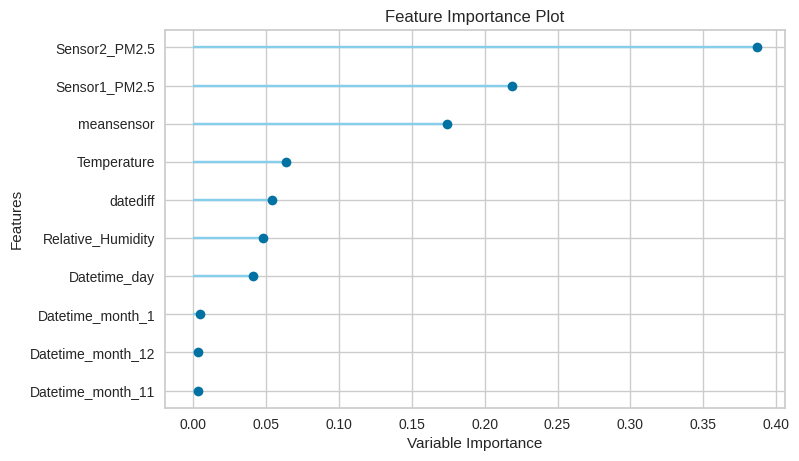

In [ ]:
plot_model(rf, plot = 'feature')

In [ ]:
rf_pred['Label'].value_counts()

0    89360
1    38001
Name: Label, dtype: int64

In [ ]:
result1 = rf_pred['Label']

In [ ]:
import numpy as np

In [ ]:
rf_pred['Label']= np.where((rf_pred['Score'] < 0.6) & (rf_pred['Label'] == 1),0, rf_pred['Label'])

In [ ]:
rf_pred['Label'].value_counts()

0    99062
1    28299
Name: Label, dtype: int64

In [ ]:
result2 = rf_pred['Label']

In [ ]:
submission['Offset_fault'] = result1
submission.to_csv('rf_pred.csv', index = False)

submission['Offset_fault'] = result2
submission.to_csv('rf_pred<0.6.csv', index = False)